In [31]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Reproduction de III

In [174]:
# Paramètres

N = 30 # nombre de transmissibilités possibles
M = 40 # nombre de résistances possibles
R0max = 15 # taux de transmission maximal
gamma = 0.09 # taux de guérison
Beta = R0max * gamma * np.arange(N) / (N - 1) # transmissibilités possibles
Omega = np.arange(M) / (M - 1) # résistances possibles
mu = 0.02 # taux de mortalité
beta_i0 = 0.2 # taux de transmission initial
i0 = int(beta_i0 * (N - 1) / (gamma * R0max)) # indice de la transmissibilité initiale
j0 = 0 # indice de la résistance initiale
sigma = 1 # taux de mutation
C = 0.5 # taux de réinfection
Xi = np.zeros((N, M, N, M)) # matrice des réinfections
for j in range(M):
    for l in range(M):
        Xi[:, j, :, l] = C * max(Omega[l] - Omega[j], 0) / M

T = 350 # durée de la simulation 
dt = 1
pop = 10**6 # population totale
h = 1 / pop

def psi(x):
    if abs(x) < h:
        return 0
    elif abs(x) > 2 * h:
        return x
    elif x <= 2 * h  and x >= h:
        return -3 * (x**3)/(h**2) + 14 * (x**2) / h - 19 * x + 8 * h
    elif x <= -h and x >= -2 * h:
        return -3 * (x**3)/(h**2) - 14 * (x**2) / h - 19 * x - 8 * h

def Psi(X):
    return np.vectorize(psi)(X)

In [179]:
# Calcul des dérivées

def dS(S, I, n, eta):
    return -n - eta * np.dot(Beta, I).sum() * S

def dV(I, V, n, eta):
    return n - eta * Beta@I@Omega * V

def dI(S, I, V, R, eta):
    return eta * Beta[:, np.newaxis] * I * S \
        + eta * Beta[:, np.newaxis] * Omega * I * V \
        - mu * I - gamma * I \
        + eta * np.tensordot(Xi, R, 2) * I \
        + Psi(gaussian_filter(I, sigma, mode='constant', cval=0) - I)
    
def dR(I, R, eta):
    return gamma * I - eta * np.tensordot(np.transpose(Xi,(2,3,0,1)), R, 2) * I
    #return gamma * I - eta * np.tensordot(np.transpose(Xi,(2,3,0,1)), I, 2) * R
    
def dD(I):
    return mu * np.sum(I)

In [180]:
# Initialisation

n = np.ones(T) * 0.006 # Taux de vaccination
eta = np.concatenate(([0.75 for _ in range(50)], [1 for _ in range(T-50)])) # NPI
I0 = np.zeros((N, M)) # matrice des infections initiale
I0[i0, j0] = 200 * 10**-5
R0 = np.zeros((N, M)) # matrice des résistances initiale
R0[i0, j0] = 0.25
S0 = 1 - np.sum(I0) - np.sum(R0)
V0 = 0
D0 = 0

In [186]:
# Simulation

def simulation(S, I, R, V, D, n, eta, dt, T):
    S_l = np.zeros(int(T/dt))
    I_l = np.zeros((int(T/dt), N, M))
    R_l = np.zeros((int(T/dt), N, M))
    D_l = np.zeros(int(T/dt))
    V_l = np.zeros(int(T/dt))

    for t in range(int(T/dt)):
        S_l[t] = S
        I_l[t] = copy.deepcopy(I)
        R_l[t] = copy.deepcopy(R)
        D_l[t] = D
        V_l[t] = V

        val = 0 if S <= 0 else n[t]
        # Newton
        Sp = dS(S, I, val, eta[t])
        Vp = dV(I, V, val, eta[t])
        Ip = dI(S, I, V, R, eta[t])
        Rp = dR(I, R, eta[t])
        Dp = dD(I)
        
        S = S + dt * Sp
        V = V + dt * Vp
        I = I + dt * Ip
        R = R + dt * Rp
        D = D + dt * Dp
    return S_l, I_l, R_l, V_l, D_l

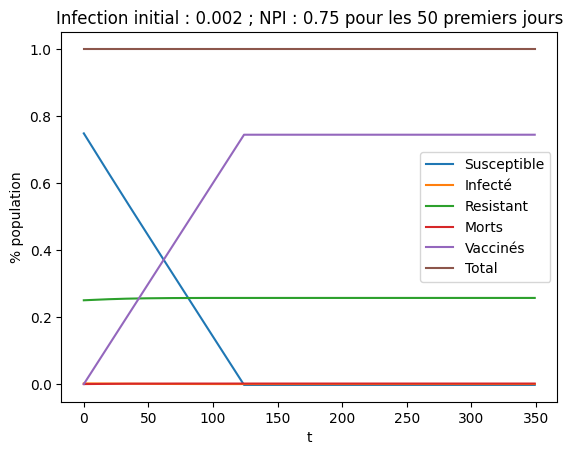

Nombre de morts : 0.0016%


In [187]:
# Résultats et Affichage
S_l, I_l, R_l, V_l, D_l = simulation(S0, I0, R0, V0, D0, n, eta, 1, T)

Is_l = [np.sum(I_l[t]) for t in range(int(T/dt))]
Rs_l = [np.sum(R_l[t]) for t in range(int(T/dt))]

plt.figure()
plt.plot(S_l, label='Susceptible')
plt.plot(Is_l, label='Infecté')
plt.plot(Rs_l, label='Resistant')
plt.plot(D_l, label='Morts')
plt.plot(V_l, label='Vaccinés')
plt.plot(S_l + Is_l + Rs_l + D_l + V_l, label='Total')
plt.xlabel('t')
plt.ylabel('% population')
plt.legend()
plt.title(f"Infection initial : {200 * 10**-5} ; NPI : 0.75 pour les 50 premiers jours")
plt.show()
print(f"Nombre de morts : {round(D_l[-1],4)}%")

# Reproduction de IV

## Méthode 1

In [21]:
# paramètres additionnels

eta_inf = 1
n_sup = 0.006
lambd = 0.1

timestep = 0.1
n_steps = int(T / timestep)

eps = 10**-3 # seuil de convergence
it_max = 100 # nombre d'itérations maximum

In [22]:
# fonctions additionnelles
def dpsi(x):
    if abs(x) < h:
        return 0
    elif abs(x) > 2 * h:
        return 1
    elif x <= 2 * h  and x >= h:
        return -9 * (x**2)/(h**2) + 28 * x / h - 19
    elif x <= -h and x >= -2 * h:
        return -9 * (x**2)/(h**2) - 28 * x / h - 19 

def Dpsi(X):
    return np.array([dpsi(e) for e in X.reshape(X.size)]).reshape(X.shape)

def make_P():
    return np.array([[[[1/(2*np.pi*sigma**2)*np.exp(-((i-k)**2+(j-l)**2)/(2*sigma**2)) for l in range(M)] for k in range(N)] for j in range(M)] for i in range(N)])

In [23]:
# dérivées additionnelles

def dpS(eta, pI, pS, I):
    return -eta * np.tensordot(pI,np.outer(Beta, np.ones(M)) * I, 2) \
        + eta * pS * np.tensordot(np.outer(Beta, np.ones(M)), I, 2)
    
def dpV(eta, pI, pV, I):
    return -eta * np.tensordot(pI,np.outer(Beta, Omega)* I, 2) \
        + eta * pV * np.tensordot(np.outer(Beta, Omega), I, 2)
        
def dpI(eta, pI, pS, pV, pR, I, R, S, V):
    return mu * (pI - np.outer(np.ones(N), np.ones(M))) \
        + gamma * (pI -pR) \
        + eta * (pS * np.outer(Beta, np.ones(M)) 
                + pI * np.outer(Beta, np.ones(M))) * S \
        + eta * (pV * np.outer(Beta, Omega) 
                - pI * np.outer(Beta, Omega)) * V \
        - np.tensordot(np.transpose(P, (2,3,0,1)), 
                       pI * Dpsi(np.tensordot(P, I, 2) - I), 2) \
        + pI * Dpsi(np.tensordot(P, I, 2) - I) \
        - eta * pI * np.tensordot(Xi, R, 2) \
        + eta * np.tensordot(np.transpose(Xi, (2,3,0,1)), R * pR, 2)

def dpR(eta, pI, pR):
    return -eta * np.tensordot(I * np.transpose(Xi,(2,3,0,1)), pI, 2)\
            +eta * np.tensordot(I, np.tensordot(Xi, pR, 2), 2)
            
def dHn(pV, pS):
    return pV - pS

def dHeta(pI, pS, pV, pR, I, R, S, V):
    return - pS * np.tensordot(np.outer(Beta, np.ones(M)), I, 2) * S \
        - pV * V * np.tensordot(np.outer(Beta, Omega), I, 2) \
        - np.tensordot(pR, np.tensordot(np.transpose(Xi, (2,3,0,1)), I, 2) * R, 2) \
        + np.tensordot(pI, np.outer(Beta, np.ones(M)) * I * S 
                       + np.outer(Beta, Omega) * I * V
                       + np.tensordot(Xi, R, 2) * I, 2)

itération 1 n-n_=  0.027436472076416776 eta-eta_=  0.0


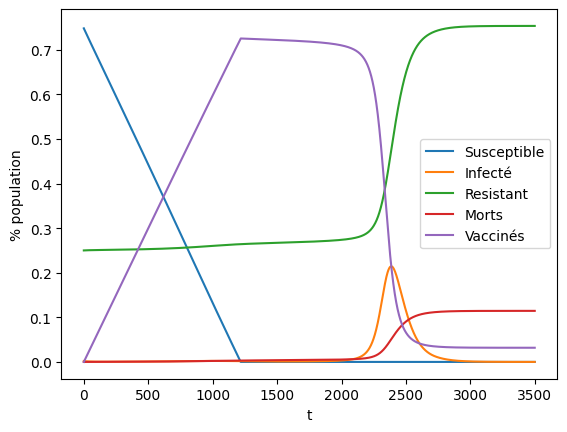

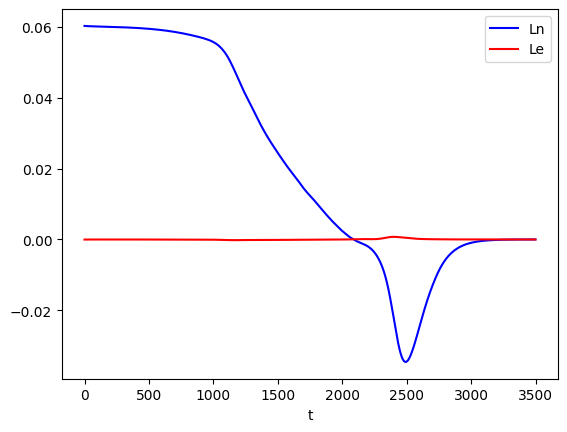

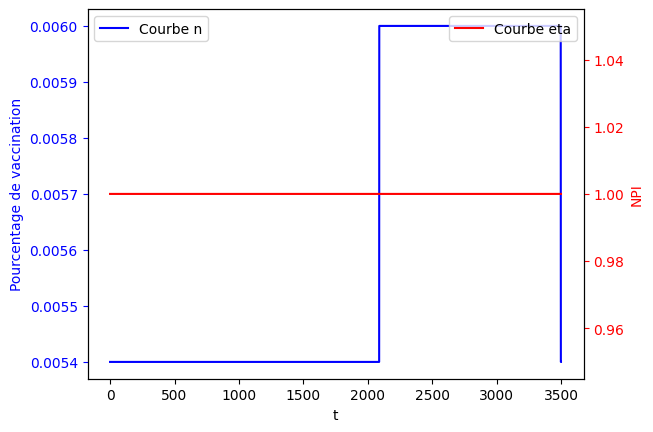

itération 2 n-n_=  0.01905044881361067 eta-eta_=  0.0
itération 3 n-n_=  0.01602156284511597 eta-eta_=  0.0
itération 4 n-n_=  0.013847781250438665 eta-eta_=  0.0
itération 5 n-n_=  0.012008315406567226 eta-eta_=  0.0
itération 6 n-n_=  0.010594385848736882 eta-eta_=  0.0


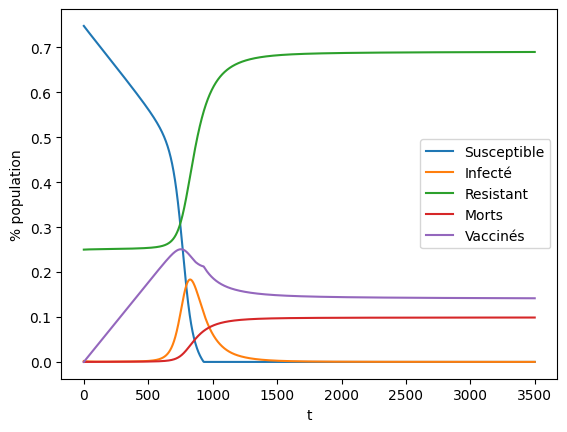

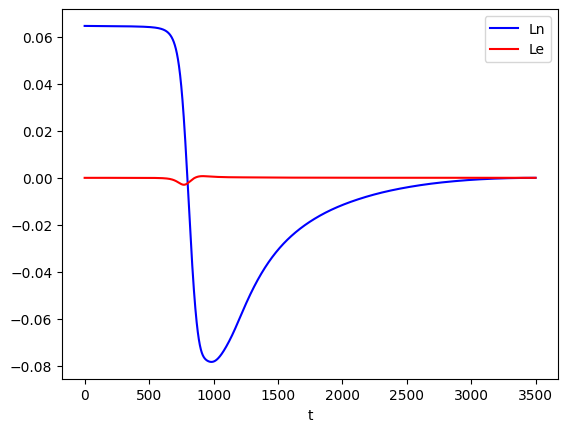

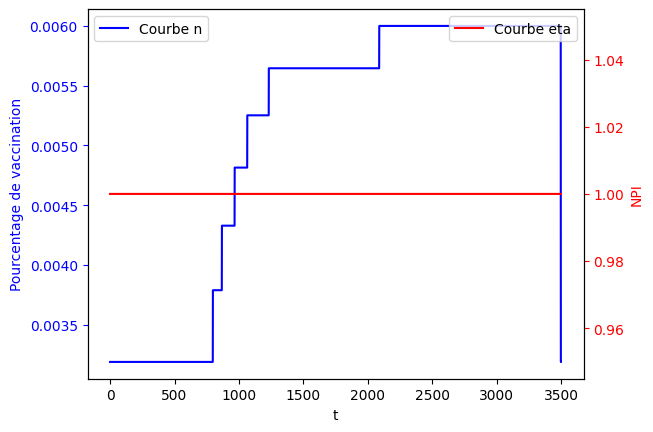

itération 7 n-n_=  0.009474212674658101 eta-eta_=  0.0
itération 8 n-n_=  0.008558801891723401 eta-eta_=  0.0
itération 9 n-n_=  0.0077837390099894975 eta-eta_=  0.0
itération 10 n-n_=  0.007120132391231367 eta-eta_=  0.0
itération 11 n-n_=  0.006542722326192992 eta-eta_=  0.0


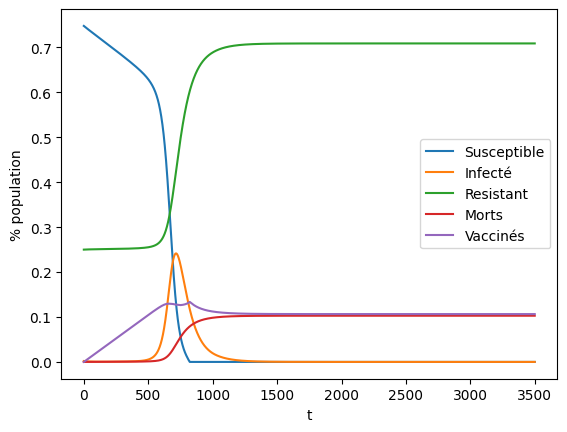

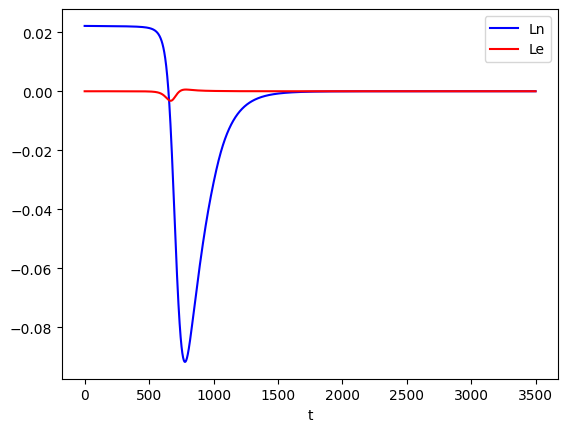

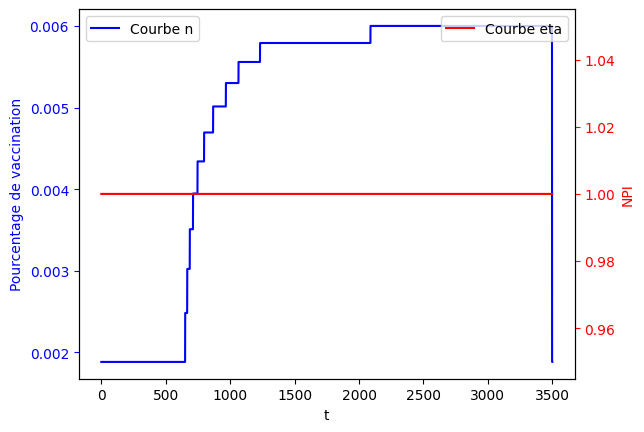

itération 12 n-n_=  0.006034614927657401 eta-eta_=  0.0
itération 13 n-n_=  0.0055875384297923245 eta-eta_=  0.0
itération 14 n-n_=  0.005201781524071534 eta-eta_=  0.0
itération 15 n-n_=  0.004825393226447898 eta-eta_=  0.0
itération 16 n-n_=  0.00451028698909736 eta-eta_=  0.0


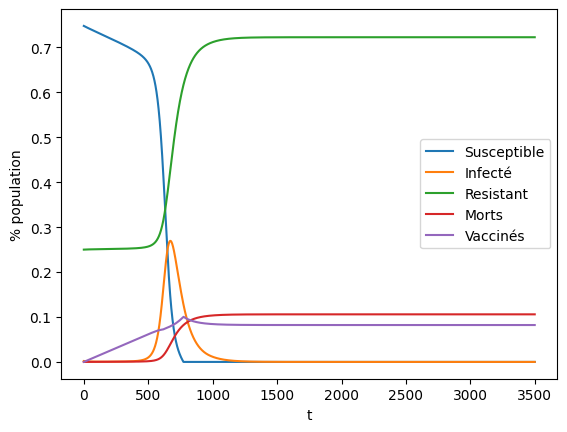

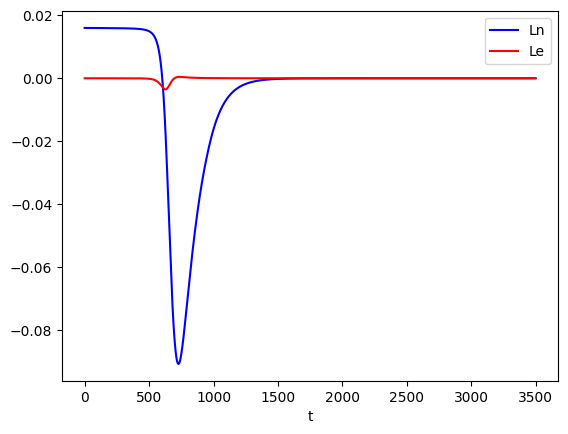

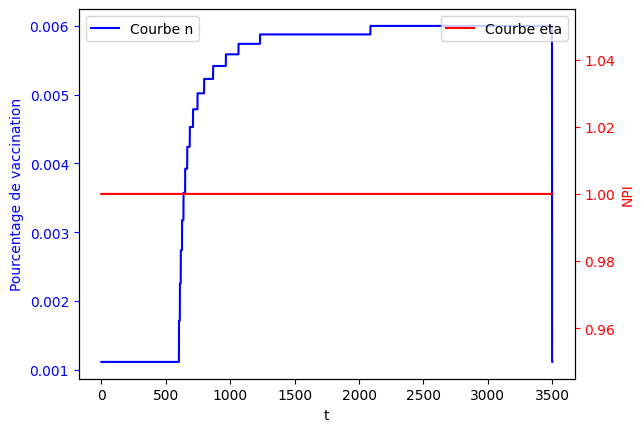

itération 17 n-n_=  0.004223395925658986 eta-eta_=  0.0
itération 18 n-n_=  0.003955711150496089 eta-eta_=  0.0
itération 19 n-n_=  0.003732861688426142 eta-eta_=  0.0
itération 20 n-n_=  0.003512506566128401 eta-eta_=  0.0
itération 21 n-n_=  0.00328799838070693 eta-eta_=  0.0


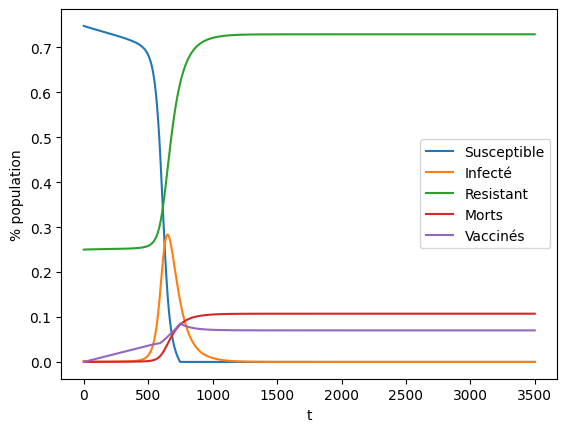

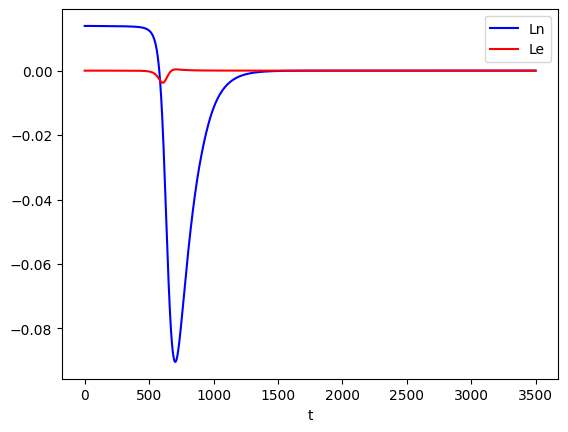

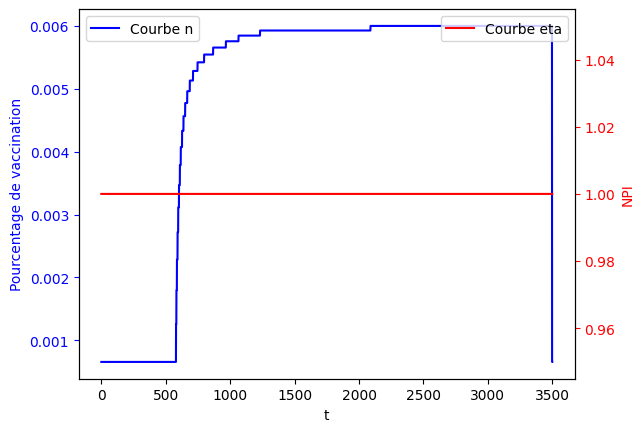

itération 22 n-n_=  0.0031435218030167523 eta-eta_=  0.0
itération 23 n-n_=  0.002929572280074227 eta-eta_=  0.0
itération 24 n-n_=  0.0028000534761680445 eta-eta_=  0.0
itération 25 n-n_=  0.002637381066926797 eta-eta_=  0.0
itération 26 n-n_=  0.0025001607133225113 eta-eta_=  0.0


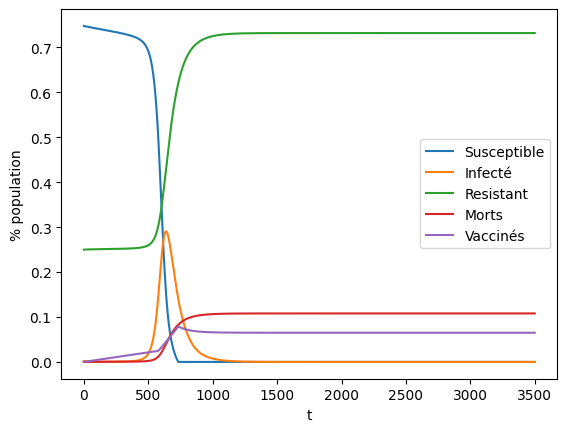

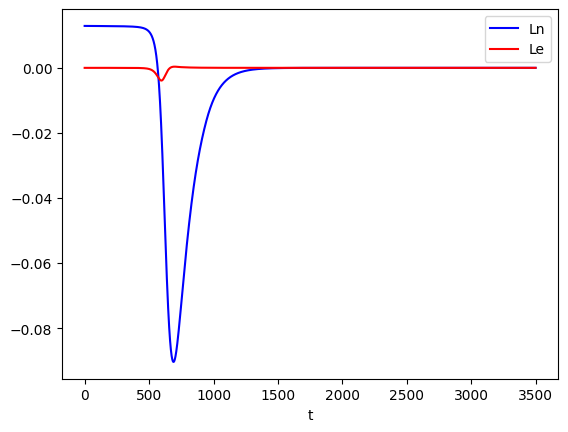

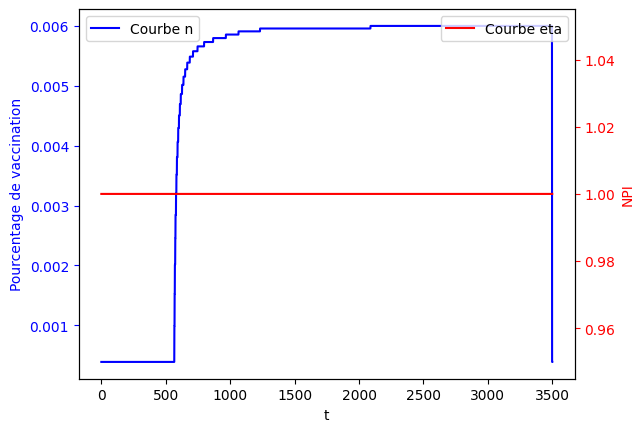

itération 27 n-n_=  0.002385395424384107 eta-eta_=  0.0
itération 28 n-n_=  0.0022197122262137135 eta-eta_=  0.0
itération 29 n-n_=  0.0021530459953930823 eta-eta_=  0.0
itération 30 n-n_=  0.002020130884518419 eta-eta_=  0.0
itération 31 n-n_=  0.001906575644031947 eta-eta_=  0.0


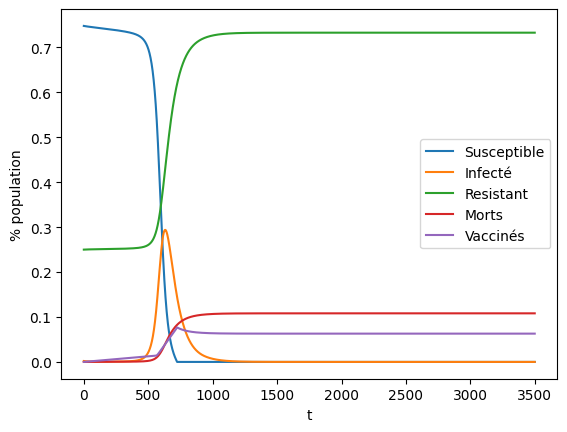

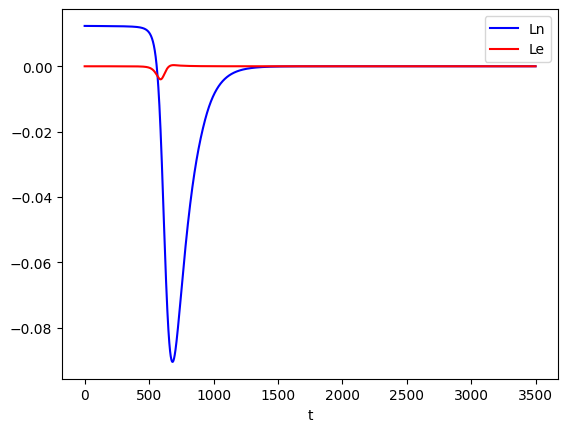

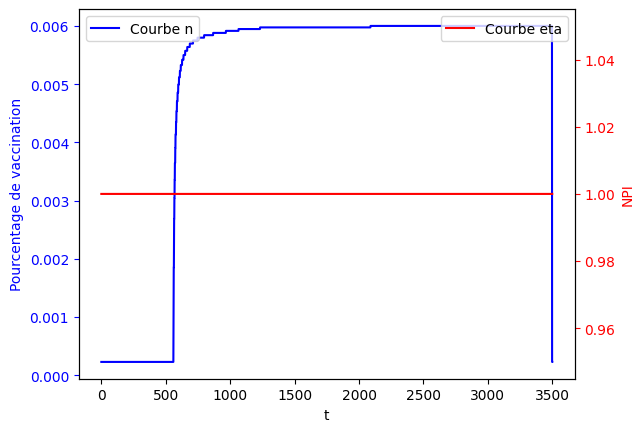

itération 32 n-n_=  0.0018102224684923322 eta-eta_=  0.0
itération 33 n-n_=  0.0017290375469306129 eta-eta_=  0.0
itération 34 n-n_=  0.0016611147185514091 eta-eta_=  0.0
itération 35 n-n_=  0.0016046836023317584 eta-eta_=  0.0
itération 36 n-n_=  0.0014442152420985853 eta-eta_=  0.0


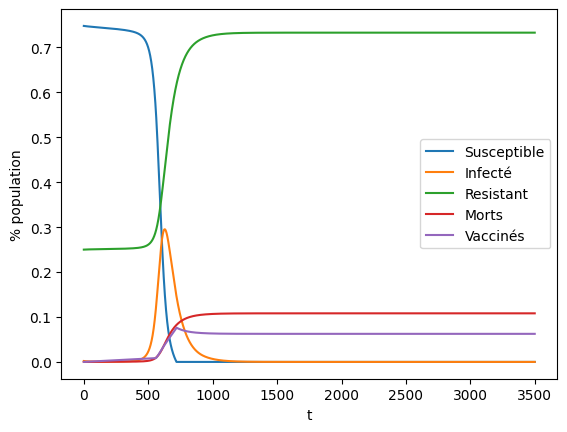

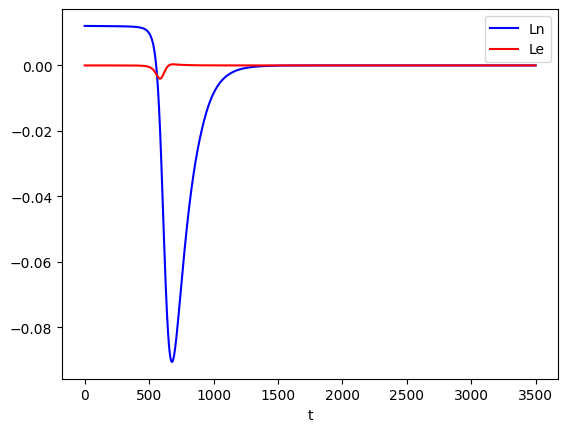

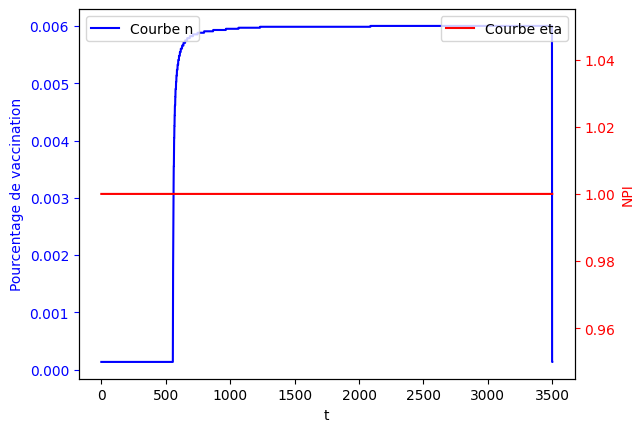

itération 37 n-n_=  0.0014259183922618577 eta-eta_=  0.0
itération 38 n-n_=  0.0014114987208004458 eta-eta_=  0.0
itération 39 n-n_=  0.0012703488487204023 eta-eta_=  0.0
itération 40 n-n_=  0.0012866009923738996 eta-eta_=  0.0
itération 41 n-n_=  0.001157940893136509 eta-eta_=  0.0


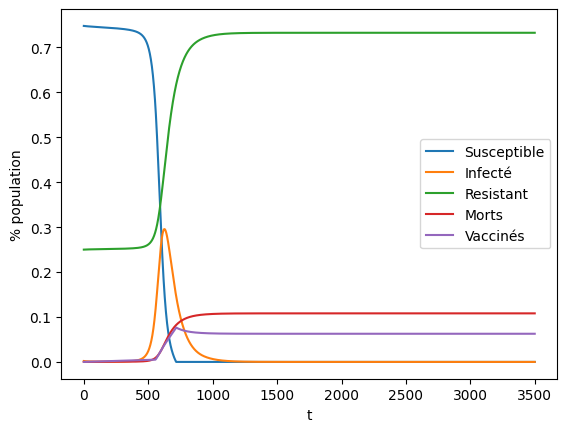

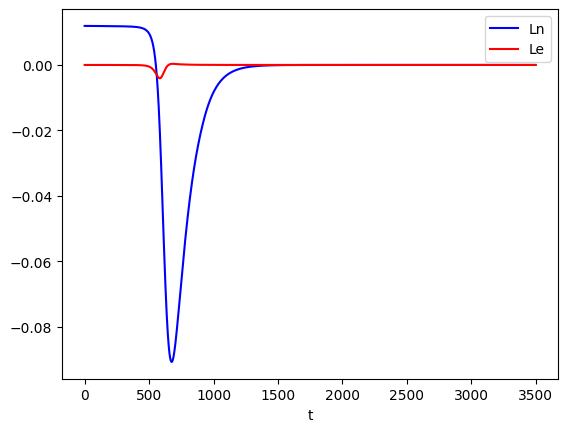

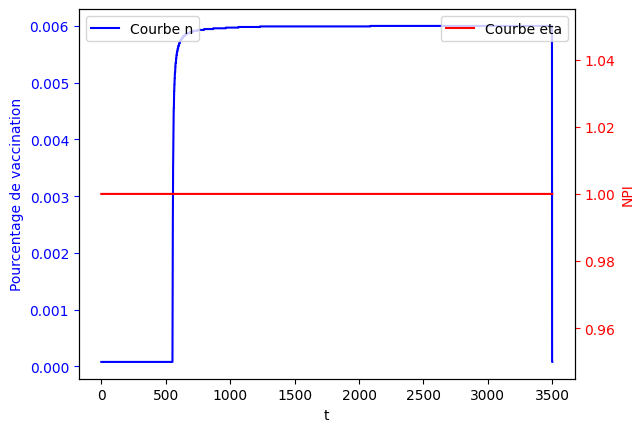

itération 42 n-n_=  0.0010421468038228601 eta-eta_=  0.0
itération 43 n-n_=  0.0011095478616311688 eta-eta_=  0.0
itération 44 n-n_=  0.000998593075468051 eta-eta_=  0.0


In [45]:
# initialisation

eta = np.array([eta_inf for _ in range(n_steps)])
n = np.array([n_sup for _ in range(n_steps)])
P = make_P()
# simulation
converged = False
it = 0
while (not converged) and (it < it_max):
    # Calcul de S, I, R, V, D
    I = np.zeros((N, M))
    I[i0, j0] = 200 * 10**-5
    R = np.zeros((N, M))
    R[i0, j0] = 0.25
    S = 1 - np.sum(I) - np.sum(R)
    V = 0
    D = 0
    
    S_l = np.zeros(n_steps)
    I_l = np.zeros((n_steps,N,M))
    R_l = np.zeros((n_steps,N,M))
    D_l = np.zeros(n_steps)
    V_l = np.zeros(n_steps)
    for t in range(n_steps):
        S_l[t] = copy.deepcopy(S)
        I_l[t] = copy.deepcopy(I)
        R_l[t] = copy.deepcopy(R)
        D_l[t] = copy.deepcopy(D)
        V_l[t] = copy.deepcopy(V)

        vac = min(n[t],S*(1/timestep-eta[t]*np.sum(I.transpose()@Beta)))
        
        Sp = dS(S, I, vac, eta[t])
        Vp = dV(I, V, vac, eta[t])
        Ip = dI(S, I, V, R, eta[t])
        Rp = dR(I, R, eta[t])
        Dp = dD(I)
        
        S = S + timestep * Sp
        V = V + timestep * Vp
        I = I + timestep * Ip
        R = R + timestep * Rp
        D = D + timestep * Dp
    
    # Modification de n et eta
    pS = 0
    pI = np.zeros((N,M))
    pR = np.zeros((N,M))
    pV = 0
    Ln_l = np.zeros(n_steps)
    Le_l = np.zeros(n_steps)
    n_ = copy.deepcopy(n)
    eta_ = copy.deepcopy(eta)
    
    for t in range(n_steps-1,-1,-1):
        # Calcul de Lambda_n et Lambda_eta
        Ln = dHn(pV, pS)
        Le = dHeta(pI, pS, pV, pR, I_l[t], R_l[t], S_l[t], V_l[t])
        
        S = S_l [t]
        V = V_l[t]
        I = I_l [t]
        R = R_l [t]
        Ln_l[t] = Ln
        Le_l[t] = Le
        # mise à jour de n et eta
        if  Ln >= 0:
            n[t] = (1-lambd)*n[t]
        else:
            n[t] = (1-lambd)*n[t] + lambd * n_sup

        if Le <= 0:
            eta[t] = (1-lambd)*eta[t] + lambd * eta_inf
        else:
            eta[t] = (1-lambd)*eta[t] + lambd
    
        # Calcul des adjoints p_S, p_I, p_R, p_V, p_D
        pSp = dpS(eta[t], pI, pS, I_l[t])
        pIp = dpI(eta[t], pI, pS, pV, pR, I_l[t], R_l[t], S_l[t], V_l[t])
        pRp = dpR(eta[t], pI, pR)
        pVp = dpV(eta[t], pI, pV, I_l[t])
        
        pS = pS - timestep * pSp
        pV = pV - timestep * pVp
        pI = pI - timestep * pIp
        pR = pR - timestep * pRp
        
        
    
    # Convergence
    if np.linalg.norm(n-n_) < eps and np.linalg.norm(eta-eta_) < eps:
        converged = True
    it += 1
    
    print("itération", it, "n-n_= ", np.linalg.norm(n-n_), "eta-eta_= ", np.linalg.norm(eta-eta_))
    
    if (it-1)%5 == 0:
        Is_l = [np.sum(I_l[t]) for t in range(n_steps)]
        Rs_l = [np.sum(R_l[t]) for t in range(n_steps)]
        plt.figure()
        plt.plot(S_l, label='Susceptible')
        plt.plot(Is_l, label='Infecté')
        plt.plot(Rs_l, label='Resistant')
        plt.plot(D_l, label='Morts')
        plt.plot(V_l, label='Vaccinés')
        plt.xlabel('t')
        plt.ylabel('% population')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(Ln_l, label='Ln',c='b')
        plt.plot(Le_l, label='Le',c='r')
        plt.xlabel('t')
        plt.legend()
        plt.show()
        
        fig, ax1 = plt.subplots()
        ax1.plot(n, 'b-', label='Courbe n')
        ax1.set_xlabel('t')
        ax1.set_ylabel('Pourcentage de vaccination', color='b')
        ax1.tick_params('y', colors='b')
        ax2 = ax1.twinx()
        ax2.plot(eta, 'r-', label='Courbe eta')
        ax2.set_ylabel('NPI', color='r')
        ax2.tick_params('y', colors='r')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()

In [ ]:
# Résultats et Affichage
Is_l = [np.sum(I_l[t]) for t in range(n_steps)]
Rs_l = [np.sum(R_l[t]) for t in range(n_steps)]
plt.figure()
plt.plot(S_l, label='Susceptible')
plt.plot(Is_l, label='Infecté')
plt.plot(Rs_l, label='Resistant')
plt.plot(D_l, label='Morts')
plt.plot(V_l, label='Vaccinés')
plt.xlabel('t')
plt.ylabel('% population')
plt.legend()
plt.show()
print(f"Nombre de morts : {round(D_l[-1],4)}%")

In [65]:
I = np.ones((N, M))

np.linalg.norm(gaussian_filter(I, sigma, mode='constant', cval=0)-np.tensordot(P, I, 2))

3.8221010500974065e-05